Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 12 - Backtesting Trading Strategies

## 12.1 Vectorized backtesting with `pandas`

### How to do it...

1. Import the libraries:

In [3]:
import pandas as pd 
import yfinance as yf
import numpy as np
import talib

2. Download Apple's stock prices from the years 2016-2021 and keep only the adjusted close price:

In [4]:
df = yf.download("AAPL", 
                 start="2016-01-01",
                 end="2021-12-31",
                 progress=False)
df = df[["Adj Close"]]


3. Calculate the log returns and the 20-day SMA of the close prices:

In [5]:
df["log_rtn"] = df["Adj Close"].apply(np.log).diff(1)
df["sma_20"] = df["Adj Close"].rolling(window=20).mean()
# df["sma_20"] = talib.SMA(df["Adj Close"], timeperiod=20)
df

,Adj Close,log_rtn,sma_20
Date,,,
2015-12-31,24.164385,NaN,NaN
2016-01-04,24.185041,0.000854,NaN
2016-01-05,23.578979,-0.025379,NaN
2016-01-06,23.117542,-0.019764,NaN
2016-01-07,22.141884,-0.043121,NaN
...,...,...,...
2021-12-23,175.797409,0.003637,169.820811
2021-12-27,179.836319,0.022715,170.993591
2021-12-28,178.799149,-0.005784,171.943483


4. Create a position indicator:

In [6]:
df["position"] = (df["Adj Close"] > df["sma_20"]).astype(int)

Using the following snippet, we count how many times we entered a long position:

In [7]:
sum((df["position"] == 1) & (df["position"].shift(1) == 0))

56

5. Visualize the strategy over 2021:

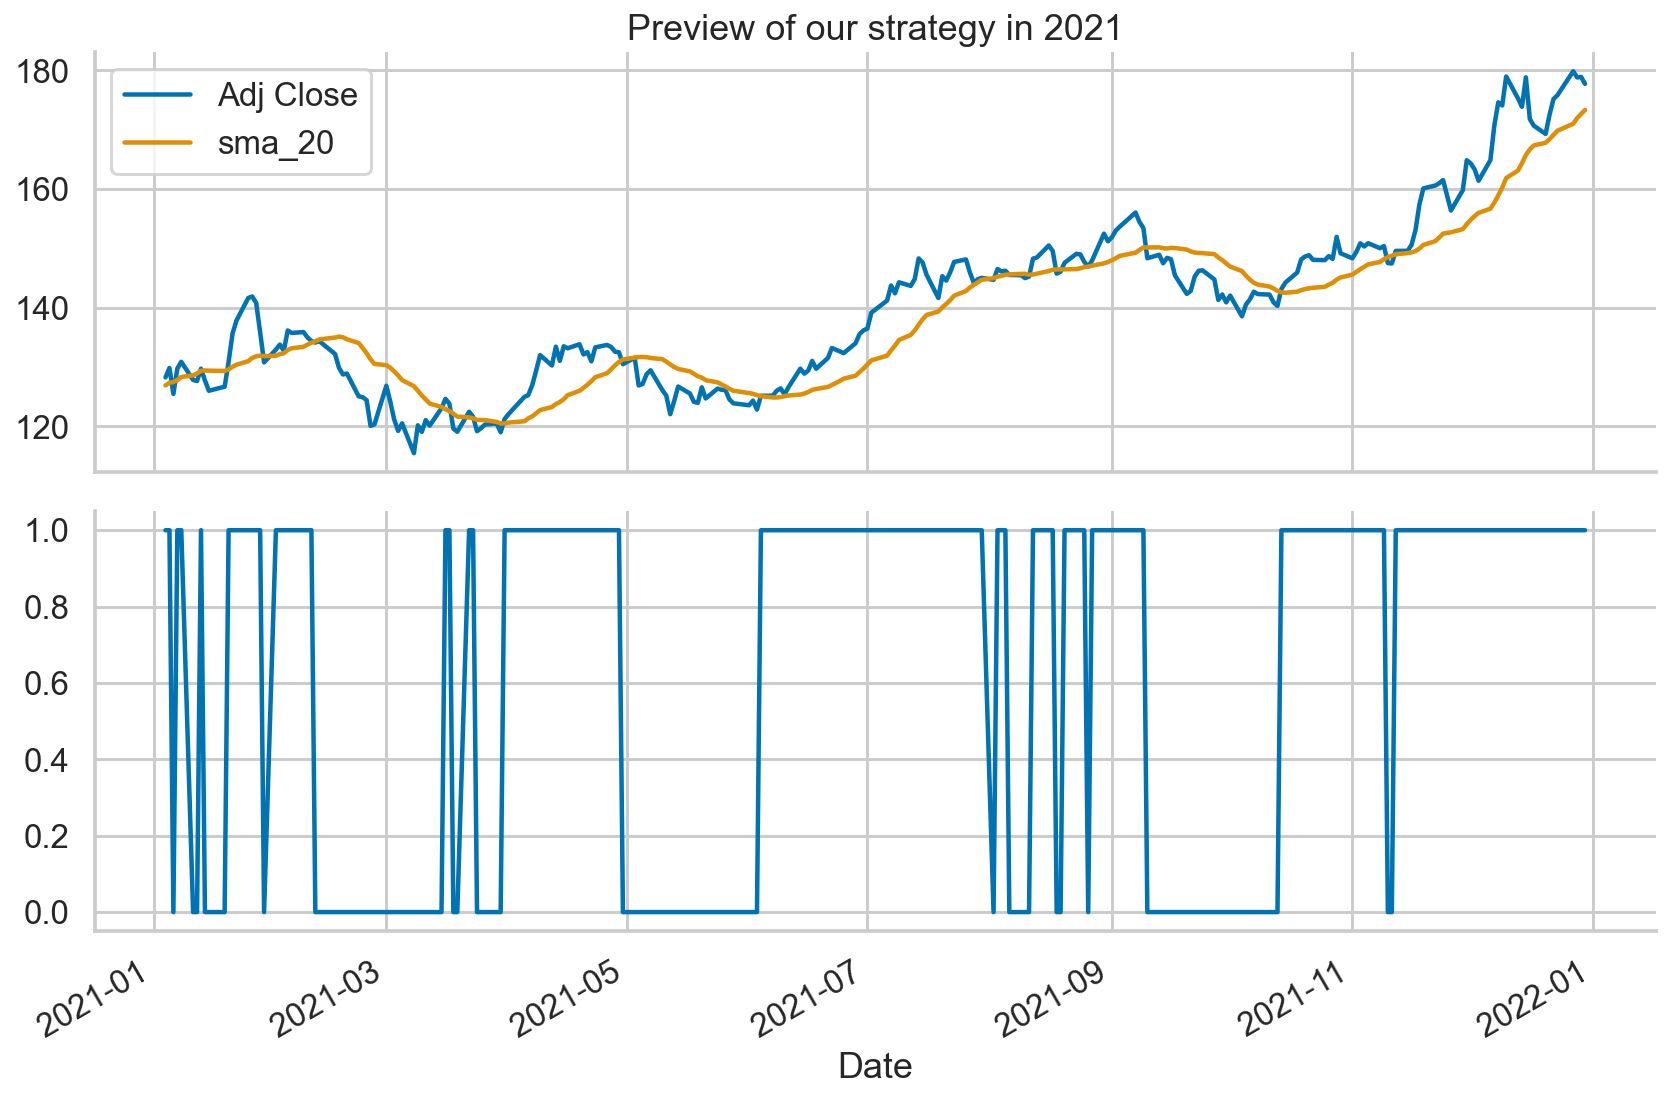

In [8]:
fig, ax = plt.subplots(2, sharex=True)
df.loc["2021", ["Adj Close", "sma_20"]].plot(ax=ax[0])
df.loc["2021", "position"].plot(ax=ax[1])
ax[0].set_title("Preview of our strategy in 2021")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_12_1", dpi=200)

6. Calculate the strategy's daily and cumulative returns:

In [9]:
df["strategy_rtn"] = df["position"].shift(1) * df["log_rtn"]
df["strategy_rtn_cum"] = df["strategy_rtn"].cumsum().apply(np.exp)
df

,Adj Close,log_rtn,sma_20,position,strategy_rtn,strategy_rtn_cum
Date,,,,,,
2015-12-31,24.164385,NaN,NaN,0,NaN,NaN
2016-01-04,24.185041,0.000854,NaN,0,0.000000,1.000000
2016-01-05,23.578979,-0.025379,NaN,0,-0.000000,1.000000
2016-01-06,23.117542,-0.019764,NaN,0,-0.000000,1.000000
2016-01-07,22.141884,-0.043121,NaN,0,-0.000000,1.000000
...,...,...,...,...,...,...
2021-12-23,175.797409,0.003637,169.820811,1,0.003637,7.976124
2021-12-27,179.836319,0.022715,170.993591,1,0.022715,8.159374
2021-12-28,178.799149,-0.005784,171.943483,1,-0.005784,8.112317


7. Add the buy-and-hold strategy for comparison:

In [10]:
df["bh_rtn_cum"] = df["log_rtn"].cumsum().apply(np.exp)

8. Plot the strategies' cumulative returns:

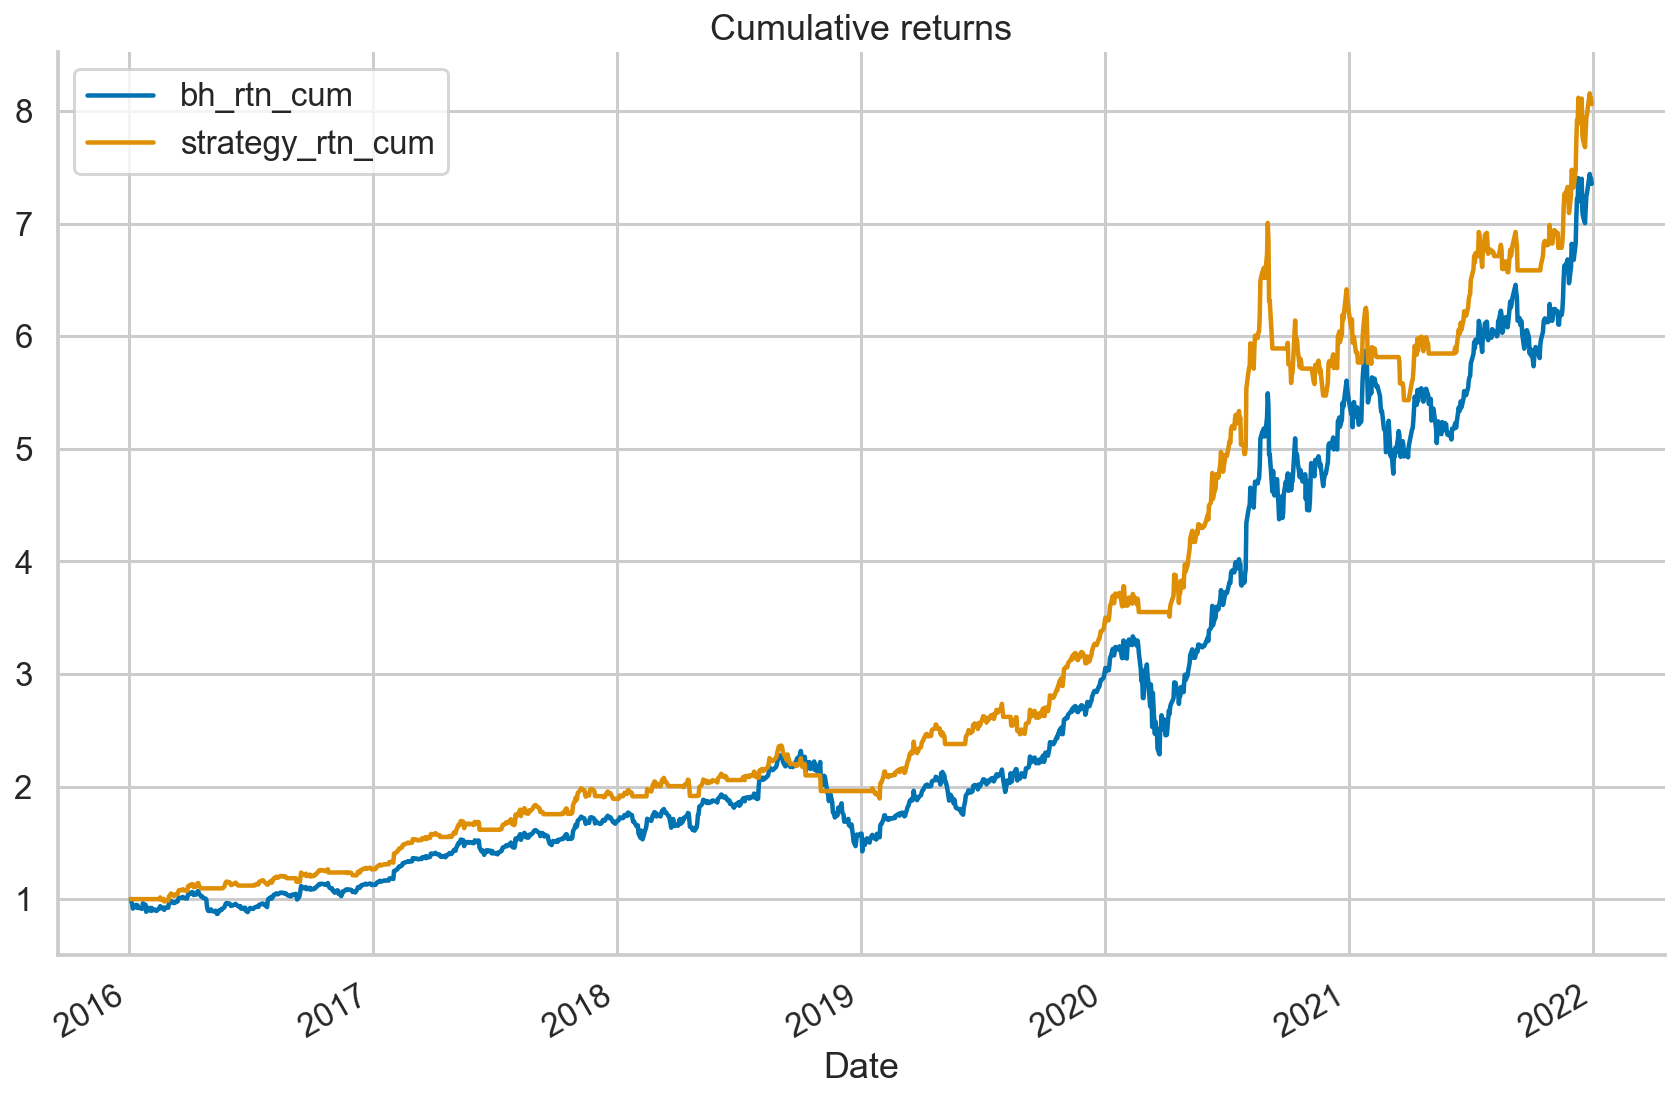

In [11]:
df[["bh_rtn_cum", "strategy_rtn_cum"]].plot(title="Cumulative returns")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_12_2", dpi=200)

### There's more

1. Calculate daily transaction costs:

In [12]:
TRANSACTION_COST = 0.01 
df["tc"] = df["position"].diff(1).abs() * TRANSACTION_COST

2. Calculate the strategy's performance accounting for transaction costs:

In [13]:
df["strategy_rtn_cum_tc"] = (
    (df["strategy_rtn"] - df["tc"]).cumsum().apply(np.exp)
)

3. Plot the cumulative returns of all the strategies:

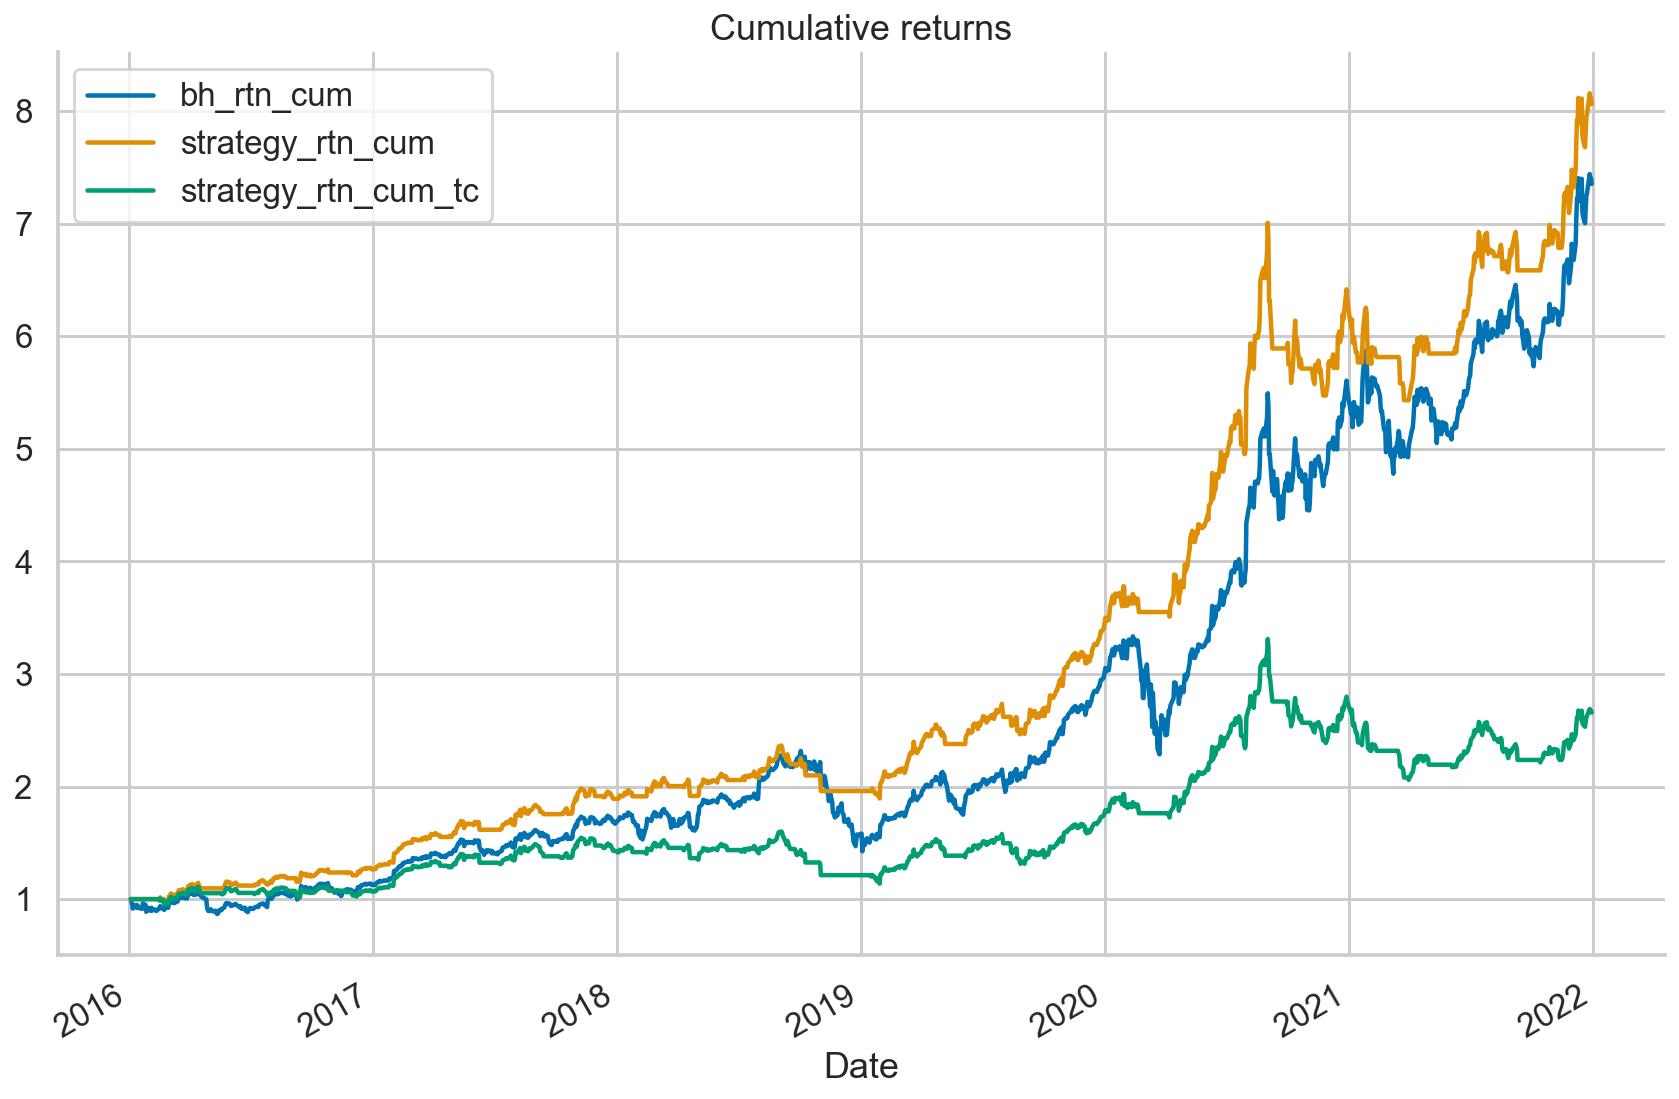

In [14]:
(
    df
    .loc[:, ["bh_rtn_cum", "strategy_rtn_cum", "strategy_rtn_cum_tc"]]
    .plot(title="Cumulative returns")
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_12_3", dpi=200)

## 12.2 Event-driven backtesting with `backtrader`

### How to do it...

1. Import the libraries:

In [15]:
from datetime import datetime
import backtrader as bt
from backtrader_strategies.strategy_utils import *

2. Download data from Yahoo Finance:

In [16]:
data = bt.feeds.YahooFinanceData(dataname="AAPL", 
                                 fromdate=datetime(2021, 1, 1),
                                 todate=datetime(2021, 12, 31))

3. Define the strategy:

In [17]:
class SmaStrategy(bt.Strategy):
    params = (("ma_period", 20), )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders
        self.order = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0],
                              period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt}: {txt}")

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:

            direction = "b" if order.isbuy() else "s"
            log_str = get_action_log_string(
                    dir=direction, 
                    action="e", 
                    price=order.executed.price,
                    size=order.executed.size,
                    cost=order.executed.value, 
                    commission=order.executed.comm
                )
            self.log(log_str)

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log("Order Failed")

        # reset order -> no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(
            get_result_log_string(gross=trade.pnl, net=trade.pnlcomm)
        )

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(
                    get_action_log_string("b", "c", self.data_close[0], 1)
                )
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:      
                self.log(
                    get_action_log_string("s", "c", self.data_close[0], 1)
                )      
                self.order = self.sell()

    def start(self):
        print(f"Initial Portfolio Value: {self.broker.get_value():.2f}")

    def stop(self):
        print(f"Final Portfolio Value: {self.broker.get_value():.2f}")

4. Set up the backtest:

In [18]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(MyBuySell)
cerebro.addobserver(bt.observers.Value)

5. Run the backtest:

In [19]:
cerebro.run()

Initial Portfolio Value: 1000.00
2021-02-01: BUY CREATED - Price: 132.95, Size: 1.00
2021-02-02: BUY EXECUTED - Price: 134.53, Size: 1.00, Cost: 134.53, Commission: 0.00
2021-02-11: SELL CREATED - Price: 134.13, Size: 1.00
2021-02-12: SELL EXECUTED - Price: 133.36, Size: -1.00, Cost: 134.53, Commission: 0.00
2021-02-12: OPERATION RESULT - Gross: -1.17, Net: -1.17
2021-03-16: BUY CREATED - Price: 124.64, Size: 1.00
2021-03-17: BUY EXECUTED - Price: 123.14, Size: 1.00, Cost: 123.14, Commission: 0.00
2021-03-18: SELL CREATED - Price: 119.64, Size: 1.00
2021-03-19: SELL EXECUTED - Price: 119.02, Size: -1.00, Cost: 123.14, Commission: 0.00
2021-03-19: OPERATION RESULT - Gross: -4.12, Net: -4.12
2021-03-22: BUY CREATED - Price: 122.48, Size: 1.00
2021-03-23: BUY EXECUTED - Price: 122.42, Size: 1.00, Cost: 122.42, Commission: 0.00
2021-03-24: SELL CREATED - Price: 119.21, Size: 1.00
2021-03-25: SELL EXECUTED - Price: 118.66, Size: -1.00, Cost: 122.42, Commission: 0.00
2021-03-25: OPERATION RE

6. Plot the results:

<IPython.core.display.Javascript object>

[[<Figure size 864x576 with 2 Axes>]]

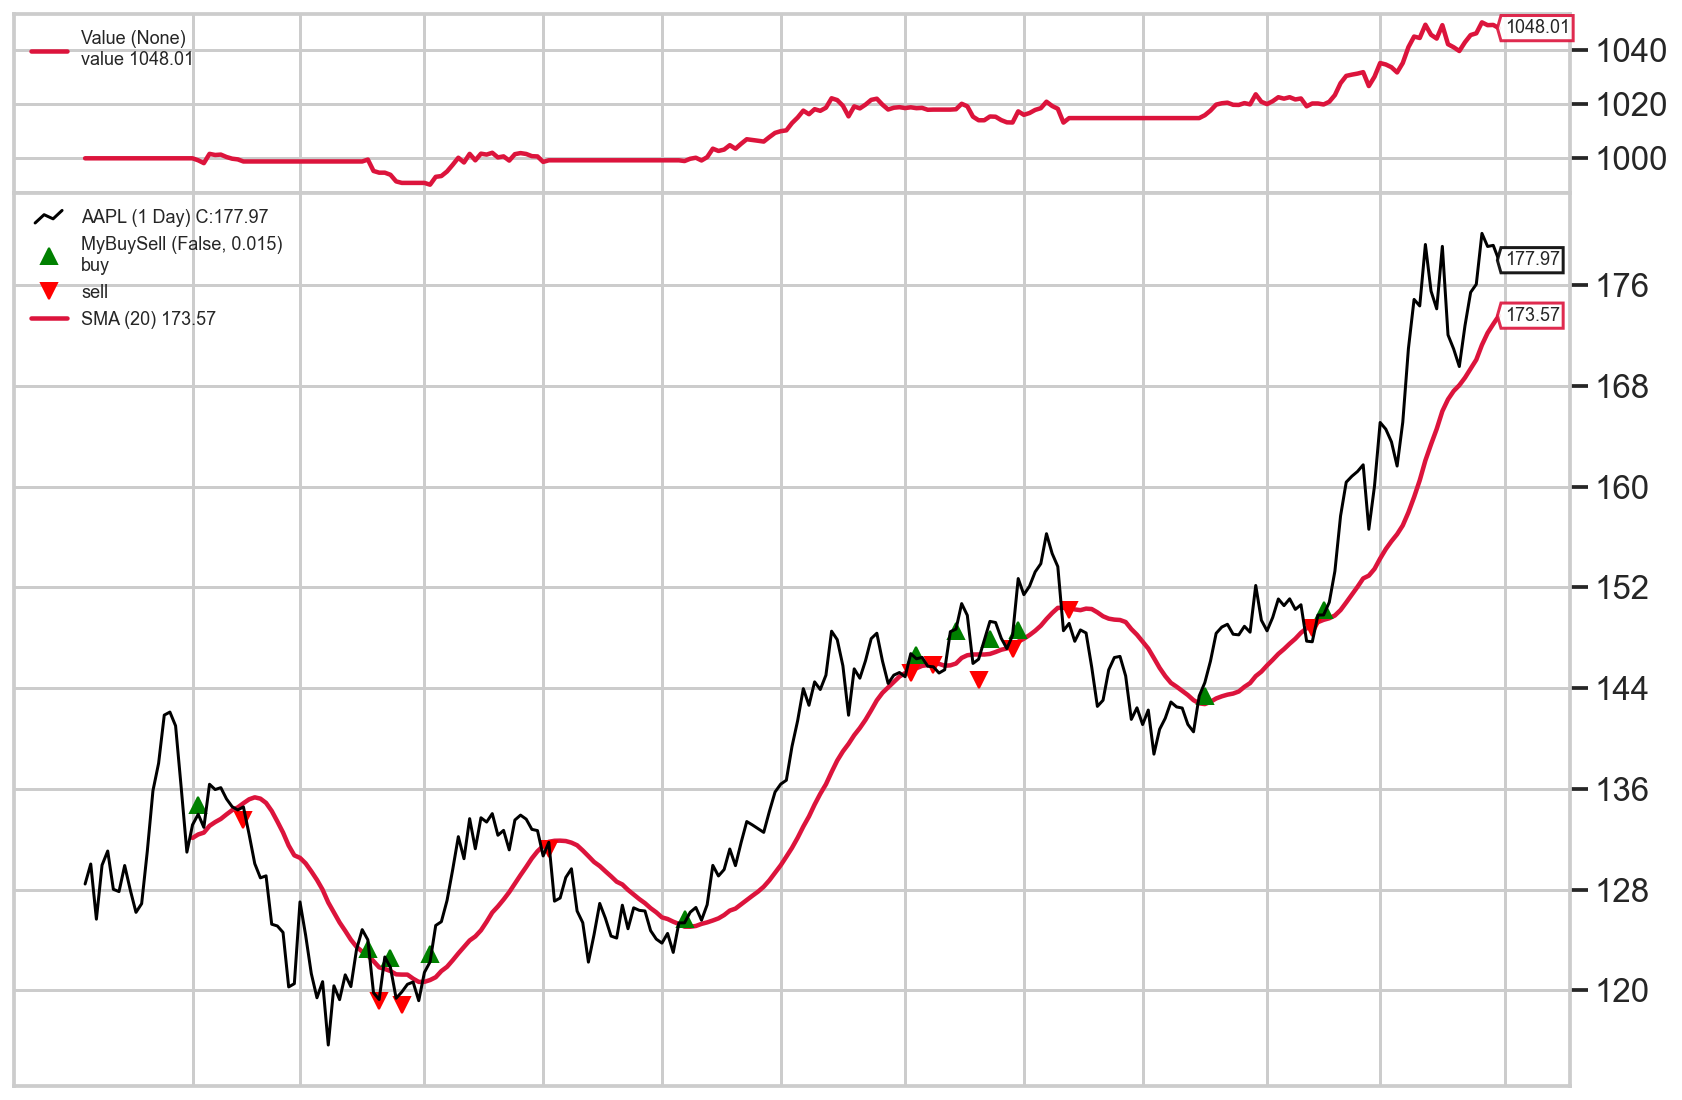

In [20]:
cerebro.plot(iplot=True, volume=False)

### There's more

Instead of running the cell below, we recommend running the script `sma_strategy_optimization.py`, as it contains the variant of the strategy without that much logging. The outputs are the same.

In [ ]:
# create a Cerebro entity
cerebro = bt.Cerebro(stdstats = False)

# set up the backtest
cerebro.adddata(data)
cerebro.optstrategy(SmaStrategy, ma_period=range(10, 31))
cerebro.broker.setcash(1000.0)
cerebro.run(maxcpus=1)


## 12.3 Backtesting a long/short strategy based on the RSI

### How to do it...

1. Import the libraries:

In [15]:
from datetime import datetime
import backtrader as bt
from backtrader_strategies.strategy_utils import *

2. Define the signal strategy based on `bt.SignalStrategy`:

In [16]:
class RsiSignalStrategy(bt.SignalStrategy):
    params = dict(rsi_periods=14, rsi_upper=70, 
                  rsi_lower=30, rsi_mid=50)

    def __init__(self):
        
        # add RSI indicator
        rsi = bt.indicators.RSI(period=self.p.rsi_periods,
                                upperband=self.p.rsi_upper,
                                lowerband=self.p.rsi_lower)

        # add RSI from TA-lib just for reference 
        bt.talib.RSI(self.data, plotname="TA_RSI")
    
        # long condition (with exit)
        rsi_signal_long = bt.ind.CrossUp(rsi, self.p.rsi_lower, plot=False)
        self.signal_add(bt.SIGNAL_LONG, rsi_signal_long)
        self.signal_add(bt.SIGNAL_LONGEXIT, -(rsi > self.p.rsi_mid))

        # short condition (with exit)
        rsi_signal_short = -bt.ind.CrossDown(rsi, self.p.rsi_upper, plot=False)
        self.signal_add(bt.SIGNAL_SHORT, rsi_signal_short)
        self.signal_add(bt.SIGNAL_SHORTEXIT, rsi < self.p.rsi_mid)

3. Download data:

In [17]:
data = bt.feeds.YahooFinanceData(dataname="FB", 
                                 fromdate=datetime(2021, 1, 1),
                                 todate=datetime(2021, 12, 31))

4. Set up and run the backtest:

In [18]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.addstrategy(RsiSignalStrategy)
cerebro.adddata(data)
cerebro.addsizer(bt.sizers.SizerFix, stake=1)
cerebro.broker.setcash(1000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(MyBuySell)
cerebro.addobserver(bt.observers.Value)

print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")
cerebro.run()
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")


Starting Portfolio Value: 1000.00
Final Portfolio Value: 1042.56


5. Plot the results:

<IPython.core.display.Javascript object>

[[<Figure size 864x576 with 4 Axes>]]

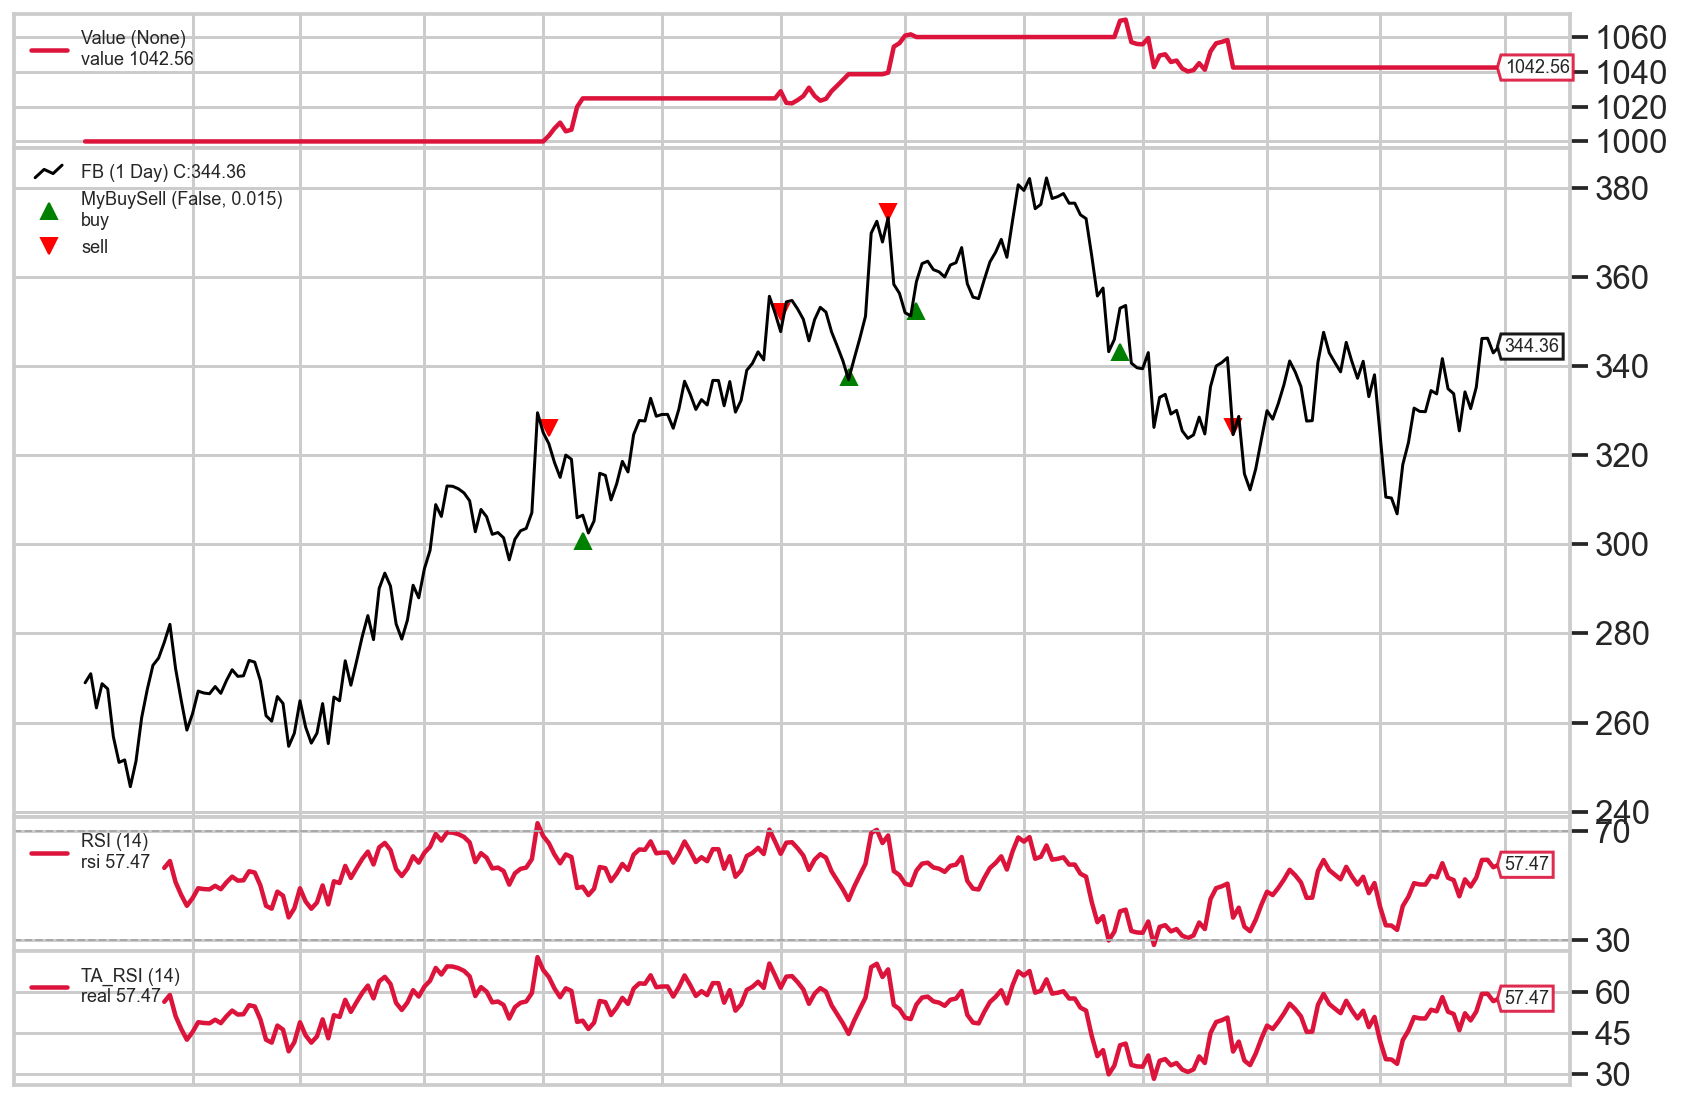

In [19]:
cerebro.plot(iplot=True, volume=False)

### There's more

1. Go "all-in" with the RSI strategy:

In [21]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.addstrategy(RsiSignalStrategy)
cerebro.adddata(data)
cerebro.addsizer(bt.sizers.AllInSizer)
cerebro.broker.setcash(1000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.Value)

print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")
cerebro.run()
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")

Starting Portfolio Value: 1000.00
Final Portfolio Value: 1183.95


2. Definte a fixed commission scheme per share and run the backtest:

In [24]:
class FixedCommisionShare(bt.CommInfoBase):
    """
    Scheme with fixed commission per share
    """
    params = (
        ("commission", 0.03),
        ("stocklike", True),
        ("commtype", bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

In [25]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.addstrategy(RsiSignalStrategy)
cerebro.adddata(data)
cerebro.addsizer(bt.sizers.AllInSizer)
cerebro.broker.setcash(1000.0)
cerebro.broker.addcommissioninfo(FixedCommisionShare())
cerebro.addobserver(bt.observers.Value)

print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")
cerebro.run()
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")


Starting Portfolio Value: 1000.00
Final Portfolio Value: 1189.94


3. Definte a fixed commission scheme per order and run the backtest:

In [26]:
class FixedCommisionOrder(bt.CommInfoBase):
    """
    Scheme with fixed commission per order
    """
    params = (
        ("commission", 2.5),
        ("stocklike", True),
        ("commtype", bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission

In [27]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.addstrategy(RsiSignalStrategy)
cerebro.adddata(data)
cerebro.addsizer(bt.sizers.AllInSizer)
cerebro.broker.setcash(1000.0)
cerebro.broker.addcommissioninfo(FixedCommisionOrder())
cerebro.addobserver(bt.observers.Value)

print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")
cerebro.run()
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")


Starting Portfolio Value: 1000.00
Final Portfolio Value: 1174.70


## 12.4 Backtesting a buy/sell strategy based on Bollinger bands

### How to do it...

1. Import the libraries:

In [28]:
import backtrader as bt
import datetime
import pandas as pd
from backtrader_strategies.strategy_utils import *

2. Define the strategy based on the Bollinger Bands:

In [29]:
class BollingerBandStrategy(bt.Strategy):
    params = (("period", 20),
              ("devfactor", 2.0),)

    def __init__(self):
        # keep track of prices
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open

        # keep track of pending orders
        self.order = None

        # add Bollinger Bands indicator and track the buy/sell signals
        self.b_band = bt.ind.BollingerBands(self.datas[0], 
                                            period=self.p.period, 
                                            devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0], 
                                           self.b_band.lines.bot,
                                           plotname="buy_signal")
        self.sell_signal = bt.ind.CrossOver(self.datas[0], 
                                            self.b_band.lines.top,
                                            plotname="sell_signal")

    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt}: {txt}")

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:

            direction = "b" if order.isbuy() else "s"
            log_str = get_action_log_string(
                    dir=direction, 
                    action="e", 
                    price=order.executed.price,
                    size=order.executed.size,
                    cost=order.executed.value, 
                    commission=order.executed.comm
                )
            self.log(log_str)

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log("Order Failed")

        # reset order -> no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(get_result_log_string(gross=trade.pnl, net=trade.pnlcomm))

    def next_open(self):
        if not self.position:
            if self.buy_signal > 0:
                # calculate the max number of shares ("all-in")
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                log_str = get_action_log_string("b", "c", 
                                                price=self.data_close[0], 
                                                size=size,
                                                cash=self.broker.getcash(),
                                                open=self.data_open[0],
                                                close=self.data_close[0])
                self.log(log_str)
                self.order = self.buy(size=size)
        else:
            if self.sell_signal < 0:
                # sell order
                log_str = get_action_log_string("s", "c", self.data_close[0], 
                                                self.position.size)
                self.log(log_str)
                self.order = self.sell(size=self.position.size)

    def start(self):
        print(f"Initial Portfolio Value: {self.broker.get_value():.2f}")

    def stop(self):
        print(f"Final Portfolio Value: {self.broker.get_value():.2f}")

3. Download data:

In [30]:
data = bt.feeds.YahooFinanceData(
    dataname='MSFT',
    fromdate=datetime.datetime(2021, 1, 1),
    todate=datetime.datetime(2021, 12, 31)
)

4. Set up the backtest:

In [31]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

cerebro.addstrategy(BollingerBandStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(MyBuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name="returns")
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="time_return")

5. Run the backtest:

In [32]:
backtest_result = cerebro.run()

Initial Portfolio Value: 10000.00
2021-03-01: BUY CREATED - Price: 235.03, Size: 42.00, Cash: 10000.00, Open: 233.99, Close: 235.03
2021-03-01: BUY EXECUTED - Price: 233.99, Size: 42.00, Cost: 9827.58, Commission: 9.83
2021-04-13: SELL CREATED - Price: 256.40, Size: 42.00
2021-04-13: SELL EXECUTED - Price: 255.18, Size: -42.00, Cost: 9827.58, Commission: 10.72
2021-04-13: OPERATION RESULT - Gross: 889.98, Net: 869.43
2021-05-07: BUY CREATED - Price: 250.42, Size: 43.00, Cash: 10869.43, Open: 250.11, Close: 250.42
2021-05-07: BUY EXECUTED - Price: 250.11, Size: 43.00, Cost: 10754.73, Commission: 10.75
2021-06-16: SELL CREATED - Price: 255.89, Size: 43.00
2021-06-16: SELL EXECUTED - Price: 257.90, Size: -43.00, Cost: 10754.73, Commission: 11.09
2021-06-16: OPERATION RESULT - Gross: 334.97, Net: 313.13
2021-09-22: BUY CREATED - Price: 297.42, Size: 37.00, Cash: 11182.56, Open: 295.58, Close: 297.42
2021-09-22: BUY EXECUTED - Price: 295.58, Size: 37.00, Cost: 10936.46, Commission: 10.94
20

6. Plot the results:

<IPython.core.display.Javascript object>

[[<Figure size 864x576 with 4 Axes>]]

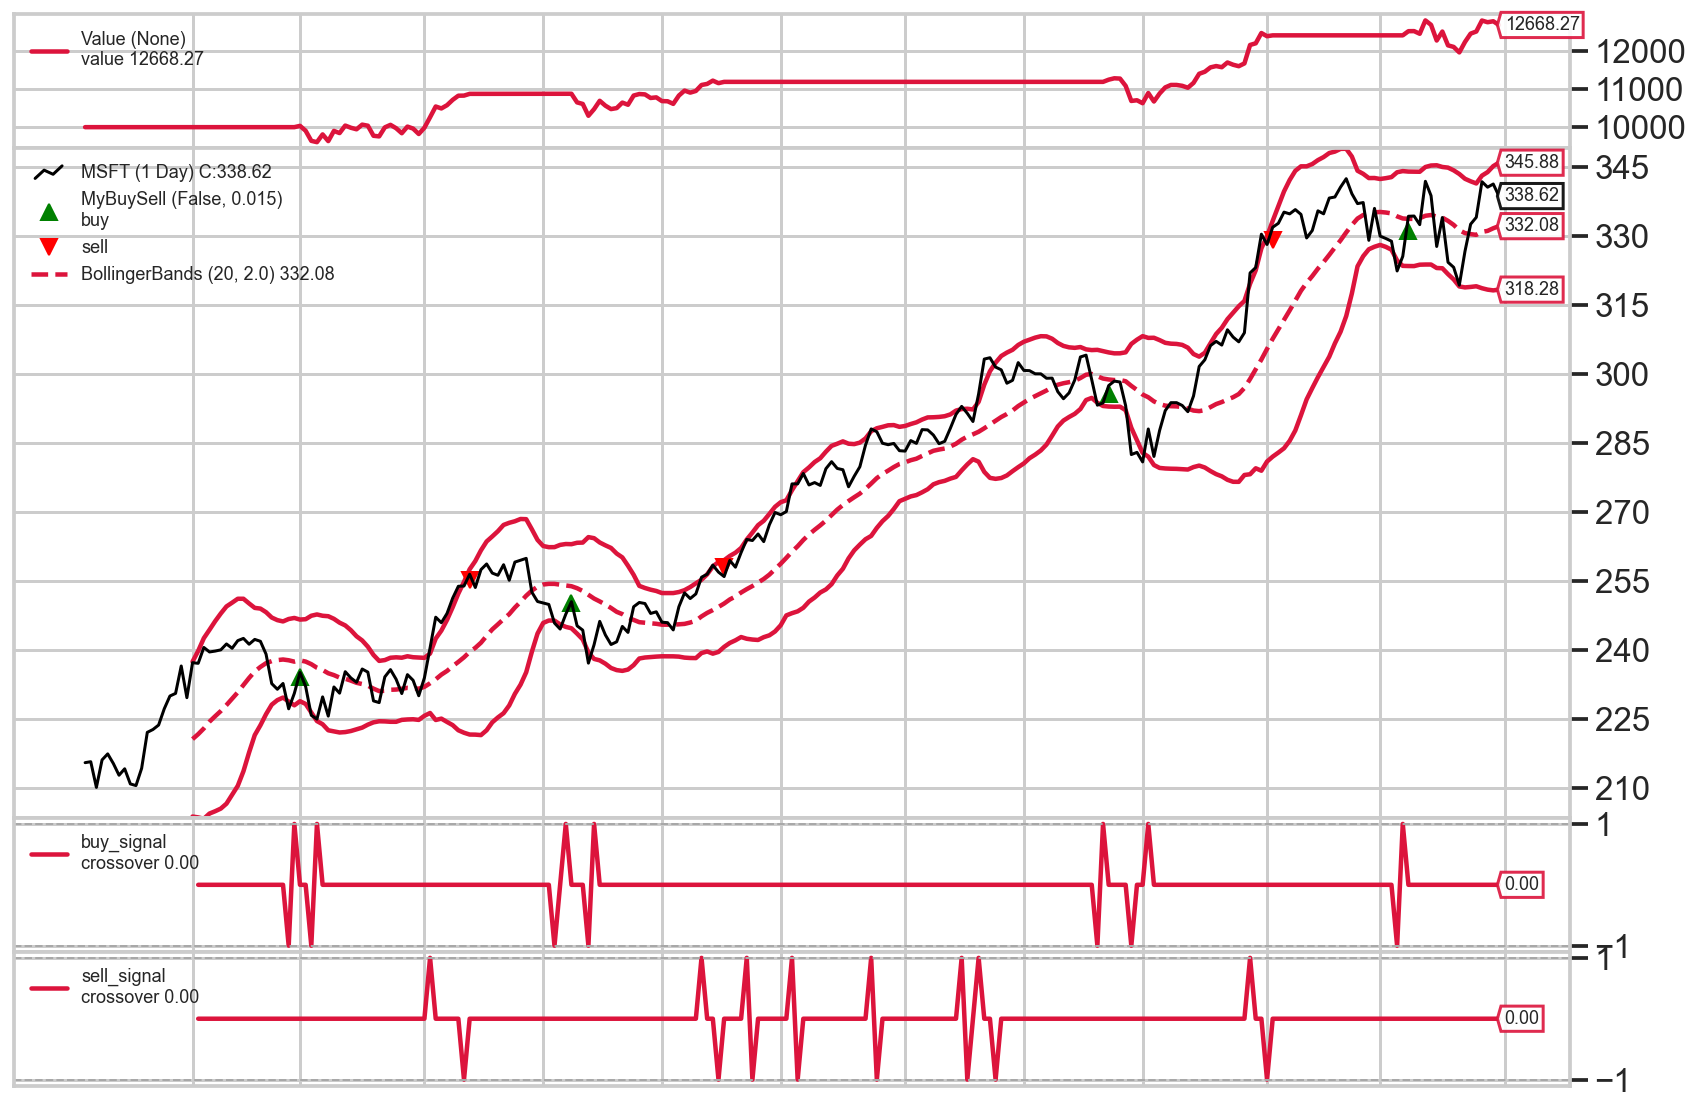

In [33]:
cerebro.plot(iplot=True, volume=False)

7. Investigate different returns metrics:

In [34]:
backtest_result[0].analyzers.returns.get_analysis()

OrderedDict([('rtot', 0.2365156915893157),
             ('ravg', 0.0009422935919893056),
             ('rnorm', 0.2680217199688534),
             ('rnorm100', 26.80217199688534)])

8. Extract daily portfolio returns and plot them:

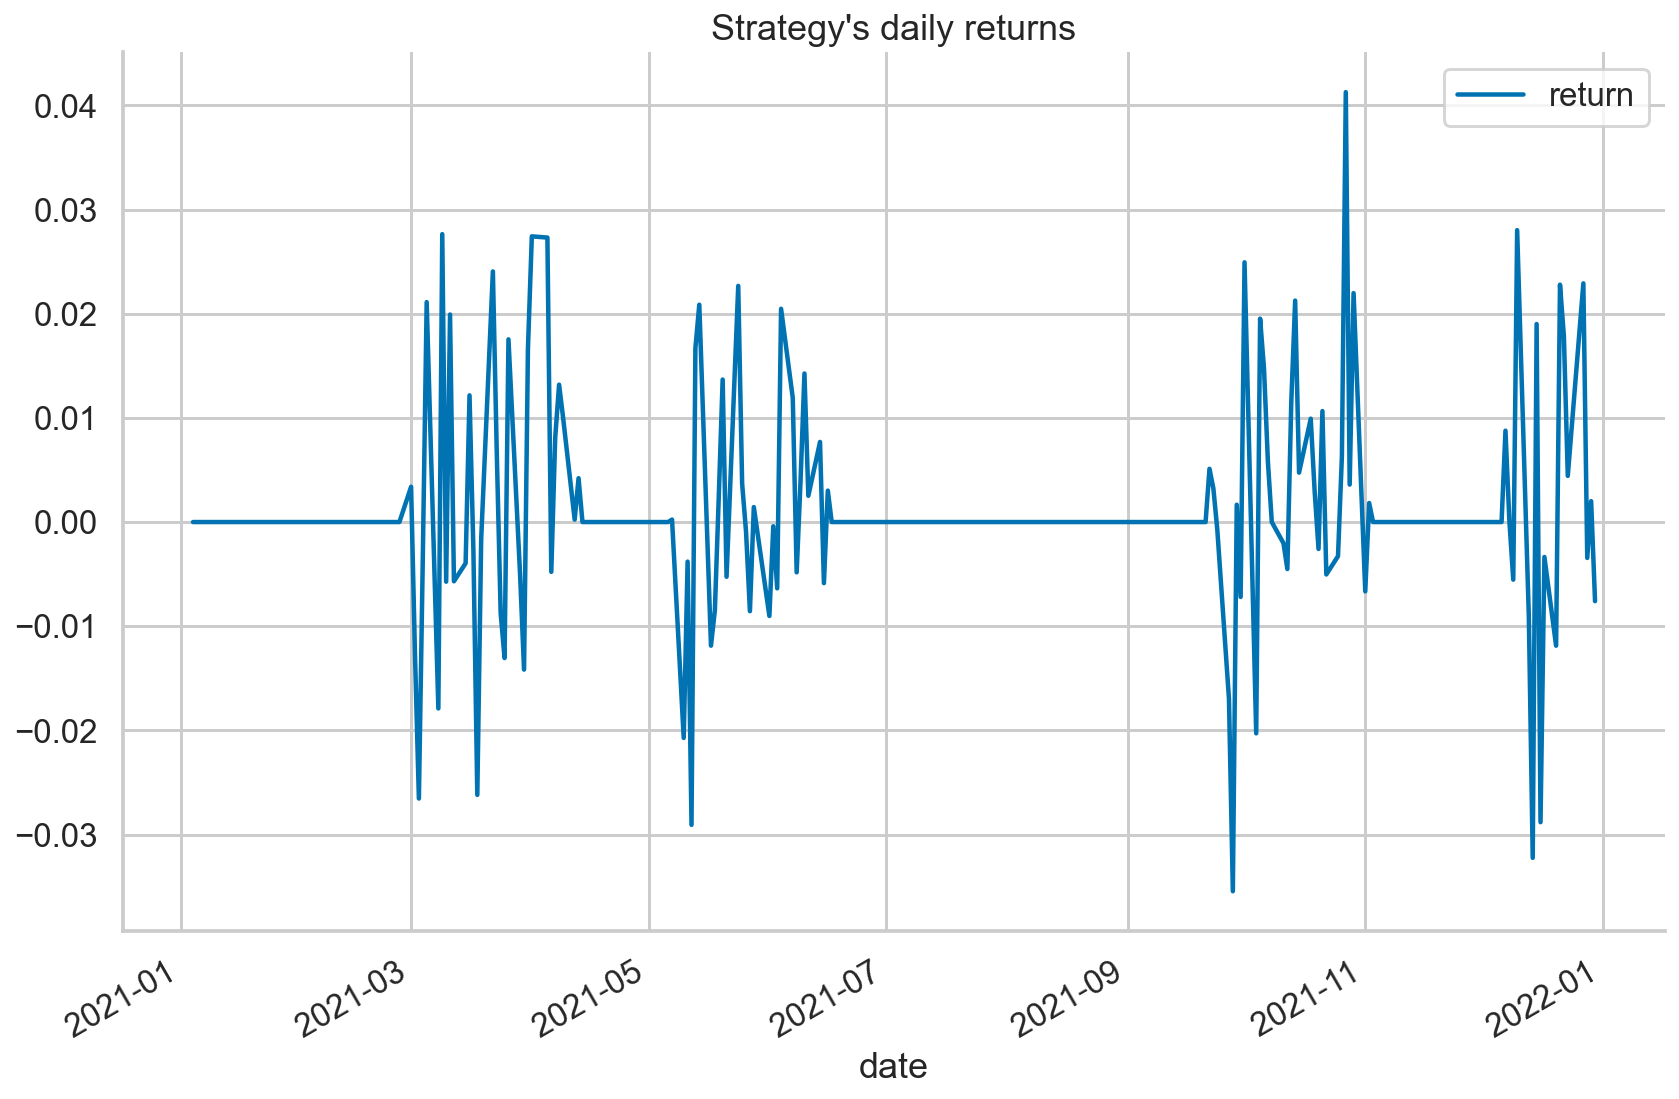

In [41]:
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), 
                          columns = ["date", "return"]) \
               .set_index("date")
returns_df.plot(title="Strategy's daily returns")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_12_7", dpi=200)

### There's more

Compare the performance of our strategy to a "buy-and-hold" strategy:

In [37]:
import quantstats as qs
qs.reports.metrics(returns_df, 
                   benchmark="MSFT", 
                   mode="basic")

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2021-01-04  2021-01-04
End Period          2021-12-30  2021-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      42.0%       100.0%

Cumulative Return   26.68%      57.18%
CAGR﹪              27.1%       58.17%

Sharpe              1.65        2.27
Sortino             2.68        3.63
Sortino/√2          1.9         2.57
Omega               1.52        1.52

Max Drawdown        -6.53%      -8.77%
Longest DD Days     99          54

Gain/Pain Ratio     0.52        0.46
Gain/Pain (1M)      4.0         6.52

Payoff Ratio        1.25        1.37
Profit Factor       1.52        1.46
Common Sense Ratio  2.59        1.67
CPC Index           1.05        1.07
Tail Ratio          1.7         1.14
Outlier Win Ratio   8.24        2.62
Outlier Loss Ratio  2.88        3.29

MTD                 2.19%       2.64%
3M                  18.56%      19.9%
6M                  13.29%      25.49%

## 12.5 Backtesting a moving average crossover strategy using crypto data

### How to do it...

1. Import the libraries:

In [15]:
import backtrader as bt
import datetime
import pandas as pd
from backtrader_strategies.strategy_utils import *

2. Define the commission scheme allowing for fractional trades:

In [16]:
class FractionalTradesCommission(bt.CommissionInfo):
    def getsize(self, price, cash):
        """Returns the fractional size"""
        return self.p.leverage * (cash / price)

3. Define the SMA crossover strategy:

In [26]:
class SMACrossoverStrategy(bt.Strategy):
    params = (
        ("ma_fast", 20),
        ("ma_slow", 50),
        ("target_perc", 0.7)
    )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        
        # keep track of pending orders
        self.order = None

        # calculate the SMAs and get the crossover signal        
        self.fast_ma = bt.indicators.MovingAverageSimple(
            self.datas[0], 
            period=self.params.ma_fast
        )
        self.slow_ma = bt.indicators.MovingAverageSimple(
            self.datas[0], 
            period=self.params.ma_slow
        )
        self.ma_crossover = bt.indicators.CrossOver(self.fast_ma, 
                                                    self.slow_ma)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt}: {txt}")

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:

            direction = "b" if order.isbuy() else "s"
            log_str = get_action_log_string(
                    dir=direction, 
                    action="e", 
                    price=order.executed.price,
                    size=order.executed.size,
                    cost=order.executed.value, 
                    commission=order.executed.comm
                )
            self.log(log_str)

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log("Order Failed")

        # reset order -> no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(get_result_log_string(gross=trade.pnl, net=trade.pnlcomm))

    def next(self):

        if self.order:
            return  # pending order execution. Waiting in orderbook

        if not self.position:
            if self.ma_crossover > 0:
                self.order = self.order_target_percent(
                    target=self.params.target_perc
                )
                log_str = get_action_log_string("b", "c", 
                                                price=self.data_close[0], 
                                                size=self.order.size,
                                                cash=self.broker.getcash(),
                                                open=self.data_open[0],
                                                close=self.data_close[0])
                self.log(log_str)

        else:
            if self.ma_crossover < 0:
                # sell order
                log_str = get_action_log_string("s", "c", self.data_close[0], 
                                                self.position.size)
                self.log(log_str)
                self.order = self.order_target_percent(target=0)

    def start(self):
        print(f"Initial Portfolio Value: {self.broker.get_value():.2f}")

    def stop(self):
        print(f"Final Portfolio Value: {self.broker.get_value():.2f}")


4. Download the `BTC-USD` data:

In [27]:
data = bt.feeds.YahooFinanceData(
    dataname="BTC-USD",
    fromdate=datetime.datetime(2020, 1, 1),
    todate=datetime.datetime(2021, 12, 31)
)

5. Set up the backtest:

In [28]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=False)

cerebro.addstrategy(SMACrossoverStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.addcommissioninfo(
    FractionalTradesCommission(commission=0.001)
)
cerebro.addobserver(MyBuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(
    bt.analyzers.TimeReturn, _name="time_return"
)

6. Run the backtest:

In [29]:
backtest_result = cerebro.run()

Initial Portfolio Value: 10000.00
2020-04-19: BUY CREATED - Price: 7189.42, Size: 0.97, Cash: 10000.00, Open: 7260.92, Close: 7189.42
2020-04-20: BUY EXECUTED - Price: 7186.87, Size: 0.97, Cost: 6997.52, Commission: 7.00
2020-06-29: SELL CREATED - Price: 9190.85, Size: 0.97
2020-06-30: SELL EXECUTED - Price: 9185.58, Size: -0.97, Cost: 6997.52, Commission: 8.94
2020-06-30: OPERATION RESULT - Gross: 1946.05, Net: 1930.11
2020-07-27: BUY CREATED - Price: 10990.87, Size: 0.76, Cash: 11930.11, Open: 9905.22, Close: 10990.87
2020-07-28: BUY EXECUTED - Price: 11017.46, Size: 0.76, Cost: 8371.28, Commission: 8.37
2020-09-09: SELL CREATED - Price: 10242.35, Size: 0.76
2020-09-10: SELL EXECUTED - Price: 10242.33, Size: -0.76, Cost: 8371.28, Commission: 7.78
2020-09-10: OPERATION RESULT - Gross: -588.96, Net: -605.11
2020-10-13: BUY CREATED - Price: 11425.90, Size: 0.69, Cash: 11325.00, Open: 11548.72, Close: 11425.90
2020-10-14: BUY EXECUTED - Price: 11429.05, Size: 0.69, Cost: 7929.68, Commiss

7. Plot the results:

<IPython.core.display.Javascript object>

[[<Figure size 864x576 with 3 Axes>]]

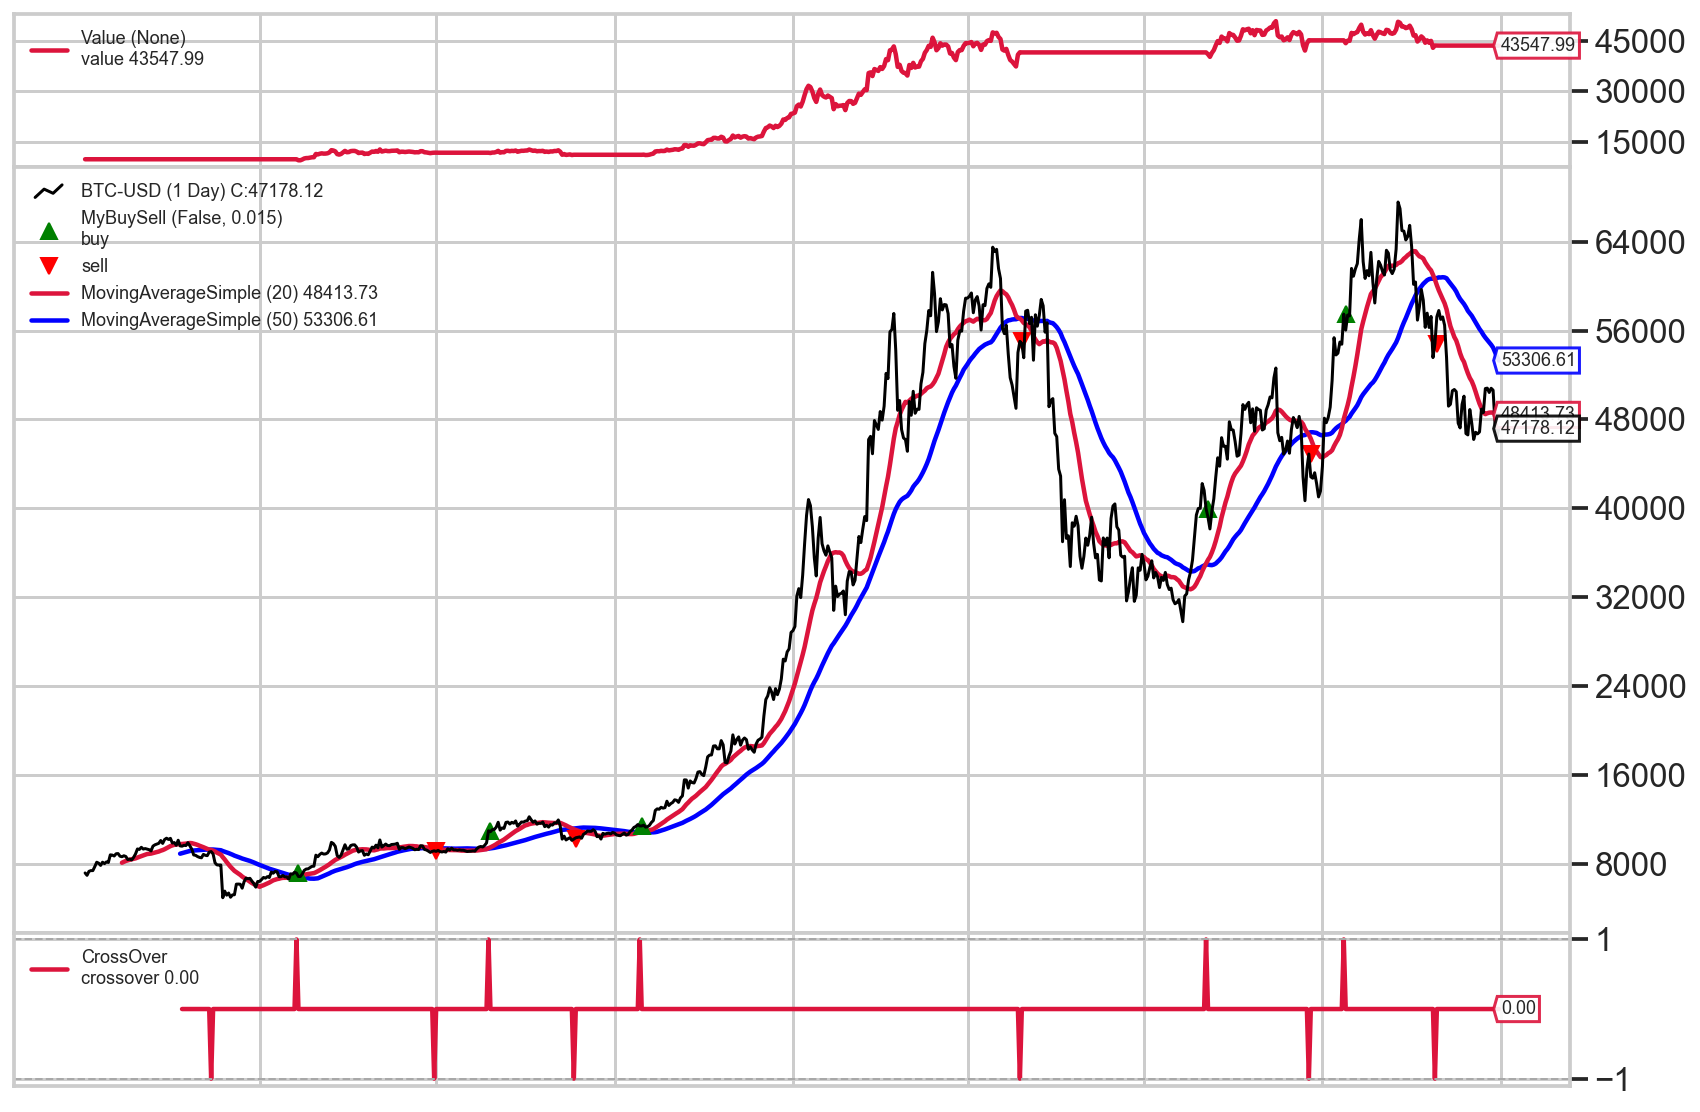

In [21]:
cerebro.plot(iplot=True, volume=False)

Get the strategy's performance as compared to a buy-and-hold strategy:

In [22]:
import quantstats as qs

# get the returns of the strategy as a DataFrame
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), 
                          columns = ["date", "return"]) \
               .set_index("date")

# calculate the perf as compared to buy-and-hold
qs.reports.metrics(returns_df, 
                   benchmark="BTC-USD", 
                   mode="basic")

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2020-01-01  2020-01-01
End Period          2021-12-30  2021-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      57.0%       100.0%

Cumulative Return   335.48%     555.24%
CAGR﹪              108.89%     156.31%

Sharpe              1.6         1.35
Sortino             2.63        1.97
Sortino/√2          1.86        1.4
Omega               1.46        1.46

Max Drawdown        -22.69%     -53.06%
Longest DD Days     151         188

Gain/Pain Ratio     0.46        0.29
Gain/Pain (1M)      6.45        2.47

Payoff Ratio        1.19        1.18
Profit Factor       1.46        1.29
Common Sense Ratio  1.95        1.59
CPC Index           0.95        0.81
Tail Ratio          1.33        1.23
Outlier Win Ratio   9.32        3.17
Outlier Loss Ratio  4.3         3.17

MTD                 0.0%        -17.24%
3M                  -3.44%      14.97%
6M                  4.85%       

### There's more

1. Define the same strategy, this time, manually calculating the amount of BTC to buy:

In [23]:
class SMACrossoverStrategyAlt(bt.Strategy):
    params = (
        ("ma_fast", 20),
        ("ma_slow", 50),
        ("target_perc", 0.7)
    )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        
        # keep track of pending orders
        self.order = None

        # calculate the SMAs and get the crossover signal        
        self.fast_ma = bt.indicators.MovingAverageSimple(self.datas[0], 
                       period=self.params.ma_fast)
        self.slow_ma = bt.indicators.MovingAverageSimple(self.datas[0], 
                       period=self.params.ma_slow)
        self.ma_crossover = bt.indicators.CrossOver(self.fast_ma, 
                                                    self.slow_ma)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt}: {txt}")

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:

            direction = "b" if order.isbuy() else "s"
            log_str = get_action_log_string(
                    dir=direction, 
                    action="e", 
                    price=order.executed.price,
                    size=order.executed.size,
                    cost=order.executed.value, 
                    commission=order.executed.comm
                )
            self.log(log_str)

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log("Order Failed")

        # reset order -> no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(get_result_log_string(gross=trade.pnl, net=trade.pnlcomm))

    def next(self):

        if self.order:
            return  # pending order execution. Waiting in orderbook

        if not self.position:
            if self.ma_crossover > 0:
                size = self.broker.getcash() / self.datas[0].close * self.params.target_perc
                log_str = get_action_log_string("b", "c", 
                                                price=self.data_close[0], 
                                                size=size,
                                                cash=self.broker.getcash(),
                                                open=self.data_open[0],
                                                close=self.data_close[0])
                self.log(log_str)
                self.order = self.buy(size=size)
        else:
            if self.ma_crossover < 0:
                # sell order
                log_str = get_action_log_string("s", "c", self.data_close[0], 
                                                self.position.size)
                self.log(log_str)
                # self.order = self.sell(size=self.position.size)
                self.order = self.order_target_percent(target=0)

    def start(self):
        print(f"Initial Portfolio Value: {self.broker.get_value():.2f}")

    def stop(self):
        print(f"Final Portfolio Value: {self.broker.get_value():.2f}")


2. Set up the backtest, this time without the fractional commission scheme:

In [24]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

cerebro.addstrategy(SMACrossoverStrategyAlt)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(MyBuySell)
cerebro.addobserver(bt.observers.Value)

3. Run the backtest:

In [25]:
backtest_result = cerebro.run()

Initial Portfolio Value: 10000.00
2020-04-19: BUY CREATED - Price: 7189.42, Size: 0.97, Cash: 10000.00, Open: 7260.92, Close: 7189.42
2020-04-20: BUY EXECUTED - Price: 7186.87, Size: 0.97, Cost: 6997.52, Commission: 7.00
2020-06-29: SELL CREATED - Price: 9190.85, Size: 0.97
2020-06-30: SELL EXECUTED - Price: 9185.58, Size: -0.97, Cost: 6997.52, Commission: 8.94
2020-06-30: OPERATION RESULT - Gross: 1946.05, Net: 1930.11
2020-07-27: BUY CREATED - Price: 10990.87, Size: 0.76, Cash: 11930.11, Open: 9905.22, Close: 10990.87
2020-07-28: BUY EXECUTED - Price: 11017.46, Size: 0.76, Cost: 8371.28, Commission: 8.37
2020-09-09: SELL CREATED - Price: 10242.35, Size: 0.76
2020-09-10: SELL EXECUTED - Price: 10242.33, Size: -0.76, Cost: 8371.28, Commission: 7.78
2020-09-10: OPERATION RESULT - Gross: -588.96, Net: -605.11
2020-10-13: BUY CREATED - Price: 11425.90, Size: 0.69, Cash: 11325.00, Open: 11548.72, Close: 11425.90
2020-10-14: BUY EXECUTED - Price: 11429.05, Size: 0.69, Cost: 7929.68, Commiss

## 12.6 Backtesting a mean-variance portfolio optimization

### Getting ready

In [3]:
import backtrader as bt

class FractionalTradesCommission(bt.CommissionInfo):
    def getsize(self, price, cash):
        """Returns the fractional size"""
        return self.p.leverage * (cash / price)

### How to do it...

1. Import the libraries:

In [4]:
from datetime import datetime
import backtrader as bt
import pandas as pd
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from backtrader_strategies.strategy_utils import *

2. Define the strategy:

In [5]:
class MeanVariancePortfStrategy(bt.Strategy):
    params = (("n_periods", 252), )

    def __init__(self):  
        # track number of days
        self.day_counter = 0
               
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt}: {txt}")

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:

            direction = "b" if order.isbuy() else "s"
            log_str = get_action_log_string(
                    asset=order.data._name,
                    dir=direction, 
                    action="e", 
                    price=order.executed.price,
                    size=order.executed.size,
                    cost=order.executed.value, 
                    commission=order.executed.comm
                )
            self.log(log_str)

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log(f"Order Failed: {order.data._name}")

        # reset order -> no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(get_result_log_string(gross=trade.pnl, net=trade.pnlcomm))

    def next(self):

        # check if we have enough data points
        self.day_counter += 1
        if self.day_counter < self.p.n_periods:
            return

        # check if the date is a Friday
        today = self.datas[0].datetime.date()
        if today.weekday() != 4: 
            return

        # find and print the current allocation
        current_portf = {}
        for data in self.datas:
            current_portf[data._name] = (
                self.positions[data].size * data.close[0]
            )
        portf_df = pd.DataFrame(current_portf, index=[0])
        print(f"Current allocation as of {today}")
        print(portf_df / portf_df.sum(axis=1).squeeze())

        # extract the past price data for each asset
        price_dict = {}
        for data in self.datas:
            price_dict[data._name] = data.close.get(0, self.p.n_periods+1)
        prices_df = pd.DataFrame(price_dict)

        # find the optimal portfolio weights
        mu = mean_historical_return(prices_df)
        S = CovarianceShrinkage(prices_df).ledoit_wolf()
        ef = EfficientFrontier(mu, S)
        weights = ef.max_sharpe(risk_free_rate=0)
        print(f"Optimal allocation identified on {today}")
        print(pd.DataFrame(ef.clean_weights(), index=[0]))

        # create orders
        for allocation in list(ef.clean_weights().items()):
            self.order_target_percent(data=allocation[0],
                                      target=allocation[1])

    def start(self):
        print(f"Initial Portfolio Value: {self.broker.get_value():.2f}")

    def stop(self):
        print(f"Final Portfolio Value: {self.broker.get_value():.2f}")

3. Download the prices of the FAANG stocks and store the data feeds in a list:

In [6]:
TICKERS = ["FB", "AMZN", "AAPL", "NFLX", "GOOG"]
data_list = []

for ticker in TICKERS:
    data = bt.feeds.YahooFinanceData(
        dataname=ticker,
        fromdate=datetime(2020, 1, 1),
        todate=datetime(2021, 12, 31)
    )
    data_list.append(data)

4. Set up the backtest:

In [7]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.addstrategy(MeanVariancePortfStrategy)

for ind, ticker in enumerate(TICKERS):
    cerebro.adddata(data_list[ind], name=ticker)

cerebro.broker.setcash(1000.0)
cerebro.broker.addcommissioninfo(
    FractionalTradesCommission(commission=0)
)
cerebro.addobserver(MyBuySell)
cerebro.addobserver(bt.observers.Value)

5. Run the backtest:

In [8]:
backtest_result = cerebro.run()

Initial Portfolio Value: 1000.00
Current allocation as of 2021-01-08
   FB  AMZN  AAPL  NFLX  GOOG
0 NaN   NaN   NaN   NaN   NaN
Optimal allocation identified on 2021-01-08
    FB     AMZN     AAPL  NFLX  GOOG
0  0.0  0.69394  0.30606   0.0   0.0
2021-01-11: Order Failed: AAPL
2021-01-11: BUY EXECUTED - Price: 157.40, Size: 4.36, Asset: AMZN, Cost: 686.40, Commission: 0.00
Current allocation as of 2021-01-15
    FB  AMZN  AAPL  NFLX  GOOG
0  0.0   1.0   0.0   0.0   0.0
Optimal allocation identified on 2021-01-15
    FB     AMZN     AAPL  NFLX  GOOG
0  0.0  0.81862  0.18138   0.0   0.0
2021-01-19: BUY EXECUTED - Price: 155.35, Size: 0.86, Asset: AMZN, Cost: 134.08, Commission: 0.00
2021-01-19: Order Failed: AAPL
Current allocation as of 2021-01-22
    FB  AMZN  AAPL  NFLX  GOOG
0  0.0   1.0   0.0   0.0   0.0
Optimal allocation identified on 2021-01-22
    FB     AMZN     AAPL  NFLX  GOOG
0  0.0  0.75501  0.24499   0.0   0.0
2021-01-25: SELL EXECUTED - Price: 166.43, Size: -0.46, Asset: 